In [126]:
# import tensorflow as tf
#
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#   try:
#     # Currently, memory growth needs to be the same across GPUs
#     for gpu in gpus:
#       tf.config.experimental.set_memory_growth(gpu, True)
#     logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#     print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#   except RuntimeError as e:
#     # Memory growth must be set before GPUs have been initialized
#     print(e)

In [127]:
import tensorflow as tf
import keras
import gensim
import sklearn
import nltk
import konlpy
import pandas as pd
import pandas_profiling
import numpy as np
import matplotlib.pyplot as plt
import re
import kss
import matplotlib.pyplot as plt
import pymssql
import pandas as pd
from matplotlib import font_manager
#%matplotlib inline
from wordcloud import WordCloud, STOPWORDS
from nltk.tokenize import sent_tokenize
from konlpy.tag import Okt
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
#tf-idf
from sklearn.decomposition import LatentDirichletAllocation
#topic modeling

from sqlalchemy import create_engine

In [141]:
pd.set_option("display.max_rows", 100)  # 출력할 최대 행 갯수를 100으로 설정
pd.set_option("display.max_columns", 500)  # 출력할 최대 열 갯수를 500개로 설정
pd.set_option("display.width", 500)  # 글자 수 기준 출력할 넓이 설정
pd.set_option("max_info_columns", 500)  # 열 기반 info가 주어질 경우, 최대 넓이

plt.style.use("seaborn-white")

user='root'
password='doslvkdlqm!'
host='192.168.1.116'
database='patent_analysis'

engine = create_engine(f'mysql+pymysql://{user}:{password}@{host}/{database}', echo=True)
patent_naver = pd.read_sql("select * from tb_patent_info where company_name='NAVER' and main_claim is not null", con=engine)
patent_kakao = pd.read_sql("select * from tb_patent_info where company_name='KAKAO' and main_claim is not null", con=engine)

# 분석대상 칼럼 : "company_name", "applicant", "application_year", "title", "main_claim", "abstract"
# print(patent_naver)
# print(patent_kakao)

2021-07-07 15:33:48,482 INFO sqlalchemy.engine.Engine SHOW VARIABLES LIKE 'sql_mode'
2021-07-07 15:33:48,483 INFO sqlalchemy.engine.Engine [raw sql] {}
2021-07-07 15:33:48,484 INFO sqlalchemy.engine.Engine SHOW VARIABLES LIKE 'lower_case_table_names'
2021-07-07 15:33:48,485 INFO sqlalchemy.engine.Engine [generated in 0.00050s] {}
2021-07-07 15:33:48,486 INFO sqlalchemy.engine.Engine SELECT DATABASE()
2021-07-07 15:33:48,487 INFO sqlalchemy.engine.Engine [raw sql] {}
2021-07-07 15:33:48,488 INFO sqlalchemy.engine.Engine SELECT COUNT(*) FROM information_schema.tables WHERE table_schema = %(table_schema)s AND table_name = %(table_name)s
2021-07-07 15:33:48,488 INFO sqlalchemy.engine.Engine [generated in 0.00037s] {'table_schema': 'patent_analysis', 'table_name': "select * from tb_patent_info where company_name='NAVER' and main_claim is not null"}
2021-07-07 15:33:48,489 INFO sqlalchemy.engine.Engine select * from tb_patent_info where company_name='NAVER' and main_claim is not null
2021-07

In [129]:
# 불용어처리
spwords = set(STOPWORDS)  # 기본적으로 많이 쓰는 단어 (제외할 단어)
spwords.add('상')  # 제외하고 싶은 단어 추가
spwords.add('그')
spwords.add('및')
spwords.add('위')
spwords.add('방법')
spwords.add('컴퓨터')
spwords.add('프로그램')
spwords.add('시스템')
spwords.add('장치')
spwords.add('상기')
spwords.add('인터넷')
spwords.add('사용자')
spwords.add('접속')
spwords.add('저장')
spwords.add('서비스')
stopwords =spwords



0       증강 현실 기반 내비게이션 환경 객체 그림자 표시 전자 동작
1                           동영상 분류 동영상 분류
2                               온라인 음악 제공
3                    문자 자동 식이 개체 기반 캡차 제공
4                       시각 정보 처리 기반 위치 인식
                      ...                
1760                  온라인 직소 퍼즐 이용 이벤트 진행
1761              이동통신 단말기 광고 표시 이동통신 단말기
1762                          관련 웹 사이트 제공
1763                     웹 메일 이용 개인 송금 제공
1764                            사이버 이용 경매
Name: title, Length: 1765, dtype: object
------------
0       증강 현실 기반 내비게이션 환경 객체 그림자 표시 전자 동작
1                           동영상 분류 동영상 분류
2                               온라인 음악 제공
3                    문자 자동 식이 개체 기반 캡차 제공
4                       시각 정보 처리 기반 위치 인식
                      ...                
1760                  온라인 직소 퍼즐 이용 이벤트 진행
1761              이동통신 단말기 광고 표시 이동통신 단말기
1762                          관련 웹 사이트 제공
1763                     웹 메일 이용 개인 송금 제공
1764                            사이버 이용 경매
Name: title, Length: 1

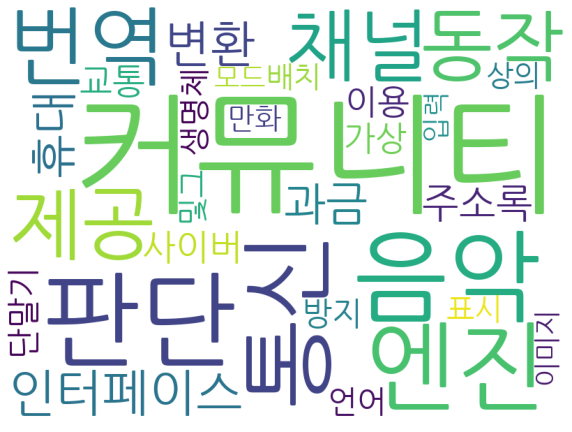

Topic 2: [('결제', 9.94), ('추출', 9.62), ('처리', 6.58), ('워드', 6.04), ('전자', 5.85), ('문서', 5.78), ('색인', 4.94), ('가격', 3.78), ('구조', 3.68), ('성장', 3.5), ('카테고리', 3.33), ('질의', 3.33), ('조정', 3.07), ('분류', 2.92), ('이용', 2.83), ('속성', 2.79), ('수행', 2.67), ('범위', 2.36), ('개수', 1.88), ('관도', 1.76), ('관계', 1.75), ('이벤트', 1.72), ('그림자', 1.71), ('캐시', 1.7), ('업데이트', 1.67), ('판매', 1.67), ('간의', 1.52), ('카탈로그', 1.43), ('지정', 1.41), ('유알', 1.33)]


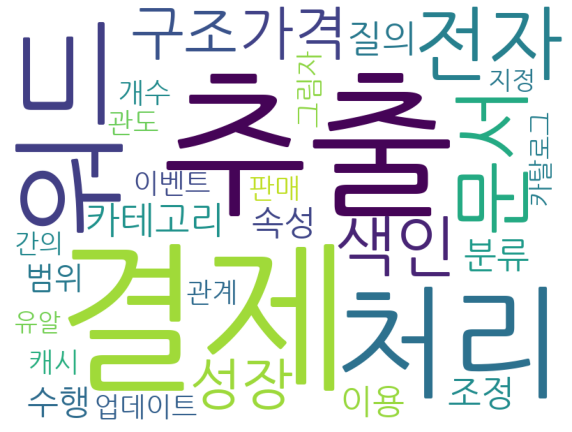

Topic 3: [('페이지', 8.56), ('필터', 5.15), ('데이터', 5.11), ('지원', 5.09), ('화상', 4.56), ('태깅', 4.17), ('컨텐츠', 3.98), ('상의', 3.83), ('보안', 3.59), ('탐색', 3.57), ('이용', 3.3), ('스크랩', 3.22), ('메모리', 3.15), ('제공', 2.9), ('테스트', 2.84), ('경로', 2.74), ('수집', 2.73), ('오프라인', 2.64), ('플레이', 2.51), ('계산', 2.32), ('마케팅', 2.3), ('기반', 2.28), ('로컬', 2.2), ('검색', 2.15), ('코드', 2.05), ('일본어', 1.96), ('미리', 1.83), ('자동화', 1.77), ('자동', 1.77), ('레이어', 1.76)]


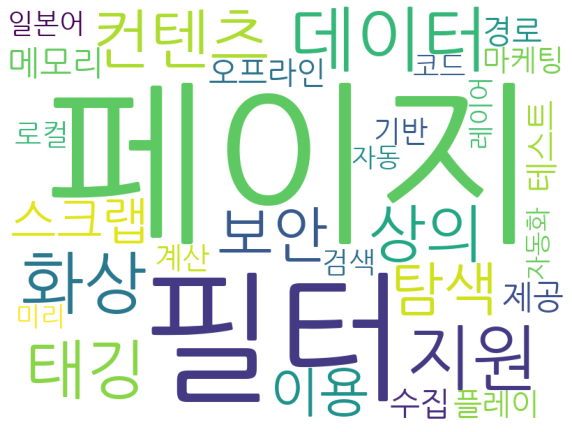

Topic 4: [('전송', 6.31), ('무선', 6.21), ('측정', 6.01), ('가로세로', 3.86), ('이용', 3.77), ('조절', 3.38), ('지도', 2.77), ('휴먼', 2.74), ('실내', 2.68), ('네트워크', 2.62), ('작성', 2.48), ('유사', 2.48), ('방식', 2.48), ('출판물', 2.47), ('네비게이션', 2.45), ('크롤', 2.3), ('영상', 2.26), ('메신저', 2.13), ('광고', 2.05), ('향상', 2.04), ('이미지', 1.94), ('상담', 1.92), ('성능', 1.89), ('액세스', 1.87), ('전문가', 1.79), ('계정', 1.76), ('퀴즈', 1.63), ('송금', 1.61), ('인터', 1.54), ('처리', 1.48)]


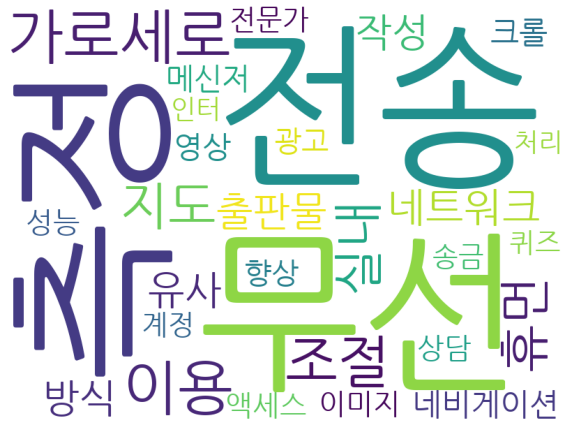

Topic 5: [('컨텐츠', 16.96), ('제공', 12.85), ('기록', 9.01), ('파일', 8.87), ('메시지', 8.4), ('입력', 8.16), ('매체', 7.99), ('제작', 7.95), ('단말', 6.96), ('이용', 6.9), ('중개', 6.9), ('전화', 6.86), ('광고', 6.47), ('판독', 6.35), ('모바일', 6.29), ('랭킹', 6.21), ('문자', 6.15), ('정보', 5.71), ('수신', 5.25), ('공격', 5.13), ('이동통신', 4.48), ('한글', 4.46), ('어플리케이션', 4.44), ('관리', 4.42), ('관련', 4.03), ('검수', 4.01), ('실시간', 3.93), ('수행', 3.44), ('설정', 3.34), ('처리', 3.23)]


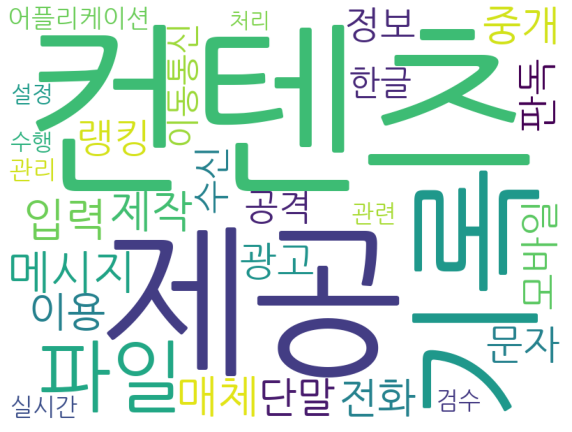

Topic 6: [('검색', 58.17), ('제공', 57.49), ('게임', 54.68), ('광고', 50.55), ('온라인', 41.25), ('정보', 32.45), ('이용', 28.9), ('관리', 23.86), ('노출', 18.1), ('이미지', 14.24), ('메일', 13.74), ('결과', 13.65), ('대한', 12.0), ('워드', 11.67), ('결정', 10.52), ('동영상', 10.09), ('기반', 9.01), ('게시', 8.91), ('클라이언트', 8.4), ('데이터베이스', 7.81), ('지역', 7.67), ('순위', 7.6), ('서버', 7.57), ('통합', 7.43), ('수행', 7.42), ('데이터', 7.25), ('위치', 7.07), ('지도', 7.01), ('변경', 6.7), ('인증', 6.65)]


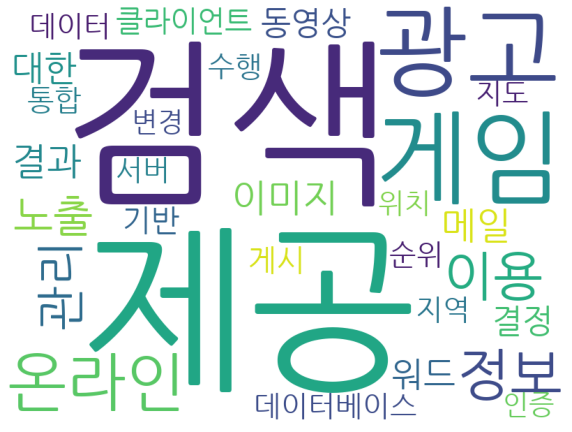

Topic 7: [('자동', 8.77), ('네트워크', 8.56), ('퍼즐', 6.24), ('블록', 5.53), ('동의어', 5.45), ('완성', 4.71), ('타겟', 4.56), ('소재', 3.5), ('소셜', 3.38), ('관리', 3.35), ('입찰', 3.01), ('광고', 2.98), ('사용', 2.58), ('중계', 2.55), ('이용', 2.55), ('이종', 2.28), ('제공', 2.2), ('및그', 2.15), ('광고주', 2.0), ('패킷', 1.98), ('마우스', 1.81), ('프레', 1.81), ('보상', 1.78), ('직소', 1.73), ('사운드', 1.51), ('노드', 1.47), ('거치', 1.46), ('개체', 1.45), ('조합', 1.44), ('러블', 1.33)]


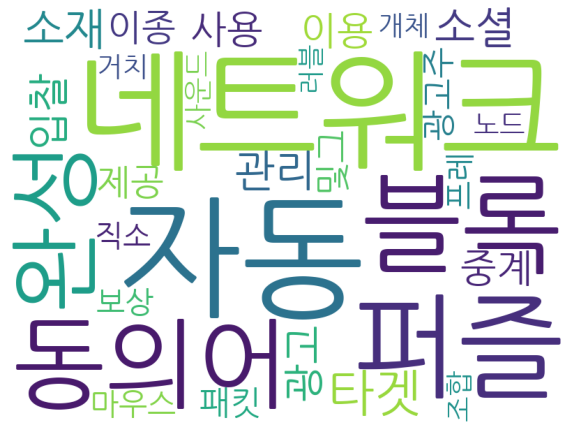

Topic 8: [('기록', 56.98), ('매체', 44.97), ('판독', 31.02), ('제공', 30.35), ('게임', 25.6), ('이용', 17.13), ('검색', 16.8), ('추천', 16.05), ('캐릭터', 14.19), ('수행', 13.52), ('단말기', 13.23), ('광고', 11.72), ('데이터', 11.62), ('서버', 11.57), ('상품', 9.67), ('실행', 9.24), ('운영', 9.2), ('정보', 8.64), ('구현', 8.05), ('결과', 7.82), ('등록', 7.68), ('기능', 7.51), ('방송', 7.37), ('온라인', 6.88), ('문서', 6.88), ('이동', 6.87), ('질의어', 6.74), ('블로그', 6.41), ('워드', 5.77), ('표시', 5.75)]


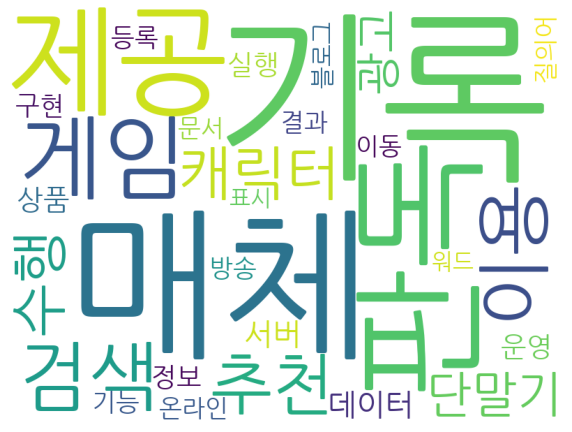

Topic 9: [('거래', 5.04), ('적립금', 4.87), ('산정', 4.28), ('아이템', 3.78), ('모니터링', 3.7), ('추가', 3.36), ('답변', 3.35), ('효율', 3.19), ('대해', 2.56), ('비용', 2.46), ('제공', 2.41), ('정보', 2.18), ('길드', 2.16), ('표현', 2.08), ('질문', 1.98), ('설명', 1.88), ('인식', 1.78), ('심리', 1.75), ('관리', 1.69), ('기반', 1.58), ('드롭', 1.55), ('거리', 1.53), ('악성코드', 1.5), ('번호', 1.49), ('탐지', 1.46), ('자동', 1.45), ('조건', 1.41), ('지리', 1.39), ('대중교통', 1.38), ('적립', 1.33)]


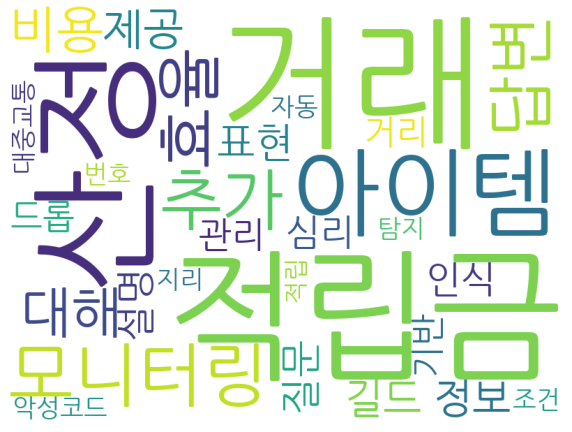

Topic 10: [('통한', 20.38), ('네트워크', 14.78), ('분석', 10.06), ('웹사이트', 5.4), ('컨텐츠', 4.4), ('연동', 4.4), ('효과', 4.29), ('웹페이지', 4.25), ('연결', 3.73), ('제공', 3.68), ('구성', 3.35), ('마일리지', 2.94), ('재생', 2.34), ('개인화', 2.3), ('인스턴트', 2.0), ('광고', 1.98), ('예약', 1.92), ('문구', 1.9), ('단위', 1.79), ('퍼블리싱', 1.77), ('활동', 1.76), ('매체', 1.71), ('스트리밍', 1.69), ('상황', 1.57), ('제어', 1.56), ('메신저', 1.53), ('아이디', 1.46), ('송수', 1.45), ('접근', 1.42), ('컴포넌트', 1.32)]


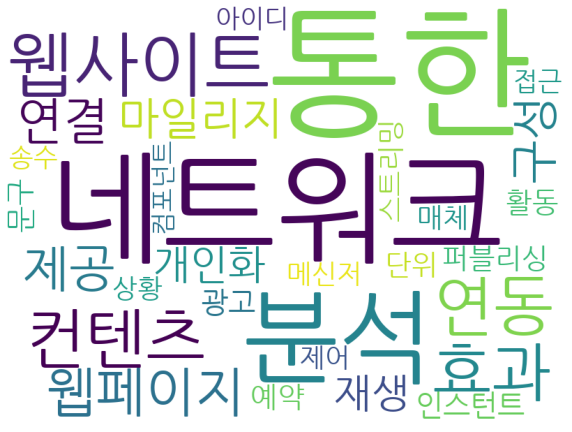

In [159]:
print(patent_naver['title'])
print("------------")

okt=Okt()
patent_naver['title'] = patent_naver.apply(lambda row: okt.nouns(row['title']), axis=1)
# print(patent_naver['title'])

patent_naver['title'] = patent_naver['title'].apply(lambda x: [word for word in x if word not in (stopwords)])
# print(patent_naver['title'])

# 역토큰화 (토큰화 작업을 되돌림)
tokenized_doc = patent_naver['title']
detokenized_doc = []
for i in range(len(patent_naver['title'])):
    t = ' '.join(tokenized_doc[i])
    detokenized_doc.append(t)

patent_naver['title'] = detokenized_doc # 다시 data['REQ_CONTENT']에 재저장
print(patent_naver['title']) # 역토큰화 잘 되었는지 확인

# TF- IDF 행렬 만들기

vectorizer = TfidfVectorizer(stopwords, max_features=1000) # 상위 1,000개의 단어를 보존
X = vectorizer.fit_transform(patent_naver['title'])
print(X.shape) # TF-IDF 행렬의 크기 확인

# 토픽 모델링
lda_model=LatentDirichletAllocation(n_components=10,learning_method='online',random_state=777,max_iter=1)
lda_top=lda_model.fit_transform(X)
print(lda_model.components_)
print(lda_model.components_.shape)

terms = vectorizer.get_feature_names() # 단어 집합. 1,000개의 단어가 저장.

wc = WordCloud(font_path='/home/anyfive/Patent_Analysis/venv/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/NanumGothic.ttf', background_color='white', width=800, height=600)

def get_topics(components, feature_names, n=30):
    for idx, topic in enumerate(components):
        print("Topic %d:" % (idx+1), [(feature_names[i], topic[i].round(2)) for i in topic.argsort()[:-n - 1:-1]])
        cloud = wc.generate_from_frequencies(dict([(feature_names[i], topic[i].round(2)) for i in topic.argsort()[:-n - 1:-1]]))
        plt.figure(figsize=(10, 8))
        plt.axis('off')
        plt.imshow(cloud)
        plt.show()

print("---- naver title topics: --------")
print(lda_model.components_)
print(terms)
get_topics(lda_model.components_,terms)


#wordCloud생성
#한글꺠지는 문제 해결하기위해 font_path 지정

# font_name = "NanumSquare"
# matplotlib.rc("font", family = font_name)


In [131]:
print(patent_kakao['title'])
print("------------")

okt=Okt()
patent_kakao['title'] = patent_kakao.apply(lambda row: okt.nouns(row['title']), axis=1)
# print(patent_kakao['title'])

patent_kakao['title'] = patent_kakao['title'].apply(lambda x: [word for word in x if word not in (stopwords)])
# print(patent_kakao['title'])

# 역토큰화 (토큰화 작업을 되돌림)
tokenized_doc = patent_kakao['title']
detokenized_doc = []
for i in range(len(patent_kakao['title'])):
    t = ' '.join(tokenized_doc[i])
    detokenized_doc.append(t)

patent_kakao['title'] = detokenized_doc # 다시 data['REQ_CONTENT']에 재저장
print(patent_kakao['title']) # 역토큰화 잘 되었는지 확인

# TF- IDF 행렬 만들기

vectorizer = TfidfVectorizer(stopwords, max_features=1000) # 상위 1,000개의 단어를 보존
X = vectorizer.fit_transform(patent_kakao['title'])
print(X.shape) # TF-IDF 행렬의 크기 확인

# 토픽 모델링
lda_model=LatentDirichletAllocation(n_components=10,learning_method='online',random_state=777,max_iter=1)
lda_top=lda_model.fit_transform(X)
print(lda_model.components_)
print(lda_model.components_.shape)

terms = vectorizer.get_feature_names() # 단어 집합. 1,000개의 단어가 저장.

def get_topics(components, feature_names, n=10):
    for idx, topic in enumerate(components):
        print("Topic %d:" % (idx+1), [(feature_names[i], topic[i].round(2)) for i in topic.argsort()[:-n - 1:-1]])
print("---- kakao title topics: --------")
get_topics(lda_model.components_,terms)




0                          메시지 서비스를 제공하는 방법  서버 및 사용자 단말
1                       동적 이모지를 표시하기 위한 단말의 동작 방법 및 그 단말
2                              애니메이션 말풍선을 표시하는 방법 및 그 단말
3      인스턴트 메시징 서비스에서 이모티콘을 제공하는 방법  이를 구현한 서버  사용자 단...
4      인스턴트 메시징 서비스에서 이모티콘을 제공하는 방법  이를 구현한 서버  사용자 단...
                             ...                        
739                                   인터넷을 이용한 금융 서비스 방법
740                                   인터넷 금융대출 서비스 중개 방법
741                                   인터넷 보험취급 서비스 중개 방법
742                                   인터넷 금융수신 서비스 중개 방법
743                                   인터넷 금융펀드 서비스 중개 방법
Name: title, Length: 744, dtype: object
------------
0                           메시지 제공 서버 단말
1                      적 이모지 표시 단말 동작 단말
2                        애니메이션 말풍선 표시 단말
3      인스턴트 메시 징 이모티콘 제공 구현 서버 단말 어플리케이션
4      인스턴트 메시 징 이모티콘 제공 구현 서버 단말 어플리케이션
                     ...                
739                                이용 금융
740                             금

In [132]:
print(patent_naver['main_claim'])
print("------------")

okt=Okt()
patent_naver['main_claim'] = patent_naver.apply(lambda row: okt.nouns(row['main_claim']), axis=1)
# print(patent_naver['main_claim'])

patent_naver['main_claim'] = patent_naver['main_claim'].apply(lambda x: [word for word in x if word not in (stopwords)])
# print(patent_naver['main_claim'])

# 역토큰화 (토큰화 작업을 되돌림)
tokenized_doc = patent_naver['main_claim']
detokenized_doc = []
for i in range(len(patent_naver['main_claim'])):
    t = ' '.join(tokenized_doc[i])
    detokenized_doc.append(t)

patent_naver['main_claim'] = detokenized_doc # 다시 data['REQ_CONTENT']에 재저장
print(patent_naver['main_claim']) # 역토큰화 잘 되었는지 확인

# TF- IDF 행렬 만들기

vectorizer = TfidfVectorizer(stopwords, max_features=1000) # 상위 1,000개의 단어를 보존
X = vectorizer.fit_transform(patent_naver['main_claim'])
print(X.shape) # TF-IDF 행렬의 크기 확인

# 토픽 모델링
lda_model=LatentDirichletAllocation(n_components=10,learning_method='online',random_state=777,max_iter=1)
lda_top=lda_model.fit_transform(X)
print(lda_model.components_)
print(lda_model.components_.shape)

terms = vectorizer.get_feature_names() # 단어 집합. 1,000개의 단어가 저장.

def get_topics(components, feature_names, n=10):
    for idx, topic in enumerate(components):
        print("Topic %d:" % (idx+1), [(feature_names[i], topic[i].round(2)) for i in topic.argsort()[:-n - 1:-1]])
print("---- naver claim topics: --------")
get_topics(lda_model.components_,terms)


0       전자 장치의 동작 방법에 있어서 상기 전자 장치의 위치를 기반으로  표시 모듈의 일...
1       슬라이드 쇼(slide show) 타입 동영상을 구별하는 동영상분류방법에 있어서  ...
2       사용자 단말의 사용자에게 음악 서비스를 제공하는 방법에 있어서 사용자 단말이 제1 ...
3       프로세서가  회전가능한 3D 개체를 생성하고  상기 3D 개체가 클라이언트 장치에서...
4       적어도 하나의 프로세서를 포함하는 컴퓨터 장치의 위치 인식 방법에 있어서 상기 적어...
                              ...                        
1760    사용자로부터 이벤트 참가신청을 수신하고 사용자에게 큐브를 제공하는 수단을 제공하는 ...
1761    이동통신단말기에 광고를 표시하는 방법에 있어서  상기 이동통신단말기에서 상기 이동통...
1762    (정정) 복수의 URL 북마크를 저장하고 있는 북마크 DB  표준 URL DB  관...
1763    송금자로부터 수금자의 전자우편 주소  송금액  송금자 결제정보를 포함한 제1 머니메...
1764    인터넷 웹사이트 상에서 제공되는 사이버머니를 이용하여 경매를 하는 방법에 있어서  ...
Name: main_claim, Length: 1765, dtype: object
------------
0       전자 동작 전자 위치 기반 표시 모듈 일부 영역 통해 표시 객체 검 출하 동작 객체...
1       슬라이드 쇼 타입 동영상 구별 동영상 분류 입력 대상 동영상 복수 프레임 추출 단계...
2       단말 음악 제공 단말 제 제 음악 컨텐츠 대한 제공 요청 입력 음악 컨텐츠 제공 요...
3       프로세서 회전 개체 생 개체 클라이언트 소정 방향 표시 개체 클라이언트 전송 클라이...
4       하나 프로세서 포함 위치 인식 하나 프로세서 카메라 통해 프레임 이미지 생 단계 하...
             

In [133]:
print(patent_kakao['main_claim'])
print("------------")

okt=Okt()
patent_kakao['main_claim'] = patent_kakao.apply(lambda row: okt.nouns(row['main_claim']), axis=1)
# print(patent_kakao['main_claim'])

patent_kakao['main_claim'] = patent_kakao['main_claim'].apply(lambda x: [word for word in x if word not in (stopwords)])
# print(patent_kakao['main_claim'])

# 역토큰화 (토큰화 작업을 되돌림)
tokenized_doc = patent_kakao['main_claim']
detokenized_doc = []
for i in range(len(patent_kakao['main_claim'])):
    t = ' '.join(tokenized_doc[i])
    detokenized_doc.append(t)

patent_kakao['main_claim'] = detokenized_doc # 다시 data['REQ_CONTENT']에 재저장
print(patent_kakao['main_claim']) # 역토큰화 잘 되었는지 확인

# TF- IDF 행렬 만들기

vectorizer = TfidfVectorizer(stopwords, max_features=1000) # 상위 1,000개의 단어를 보존
X = vectorizer.fit_transform(patent_kakao['main_claim'])
print(X.shape) # TF-IDF 행렬의 크기 확인

# 토픽 모델링
lda_model=LatentDirichletAllocation(n_components=10,learning_method='online',random_state=777,max_iter=1)
lda_top=lda_model.fit_transform(X)
print(lda_model.components_)
print(lda_model.components_.shape)

terms = vectorizer.get_feature_names() # 단어 집합. 1,000개의 단어가 저장.

def get_topics(components, feature_names, n=10):
    for idx, topic in enumerate(components):
        print("Topic %d:" % (idx+1), [(feature_names[i], topic[i].round(2)) for i in topic.argsort()[:-n - 1:-1]])
print("---- kakao claim topics: --------")
get_topics(lda_model.components_,terms)


0      메신저 서버에서 수행되는 메시지 서비스 제공 방법에 있어서 그룹 채팅을 위한 적어도...
1      인스턴트 메시징 서비스의 메시지가 적어도 하나의 동적 이모지- 상기 동적 이모지는 ...
2      인스턴트 메시징 서비스를 통하여  메시지를 수신하는 단계;상기 메시지가 텍스트 데이...
3      단말이 인스턴트 메시징 어플리케이션의 사용자 인터페이스 화면을 제공하는 방법으로서 ...
4      단말이 이모티콘을 제공하는 방법으로서 키워드별 매칭 텍스트들을 포함하는 키워드 딕셔...
                             ...                        
739    사용자 컴퓨터 시스템  가상은행 컴퓨터 시스템  금융기관 컴퓨터 시스템이 네트워크로...
740    인터넷 사용자가 인터넷에 접속하고  금융대출기관의 안내에 따라 금융대출 상품정보를 ...
741    인터넷 사용자가 인터넷에 접속하고  보험취급기관의 안내에 따라 보험가입에 대한 상품...
742    인터넷 사용자가 인터넷에 접속하고  금융수신기관의 안내에 따라 수신상품 정보를 취득...
743    인터넷 사용자가 인터넷에 접속하여 투자유치기관의 안내에 따라 투자상품 정보를 취득한...
Name: main_claim, Length: 744, dtype: object
------------
0      메신저 서버 수행 메시지 제공 그룹 채팅 하나 오픈 채팅 방 생 단계 그룹 채팅 접...
1      인스턴트 메시 징 메시지 하나 적 이모지 적 이모 정적 이모지 구별 시각 효과 인 ...
2      인스턴트 메시 징 통 메시지 수신 단계 메시지 텍스트 데이터 하나 적 이모지 적 이...
3      단말 인스턴트 메시 징 어플리케이션 인터페이스 화면 제공 텍스트 입력 창 이모티콘 ...
4      단말 이모티콘 제공 키 워드 별 매칭 텍스트 포함 키 워드 딕셔너리 단계 텍스트 입...
                             .